In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
# License: MIT

# PCA of HadISST SST anomalies

This notebook contains routines for computing the EOFs of the SST anomalies as part
of the first case study.

## Packages

In [2]:
%matplotlib inline

import os
import time

import cartopy.crs as ccrs
import cmocean
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import xarray as xr

from cartopy.util import add_cyclic_point
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
from sklearn.metrics import mean_squared_error
from sklearn.utils import check_random_state

## Analysis parameters

In [4]:
RANDOM_SEED = 0

random_state = check_random_state(RANDOM_SEED)

TIME_NAME = 'time'
LAT_NAME = 'latitude'
LON_NAME = 'longitude'
ANOMALY_NAME = 'sst_anom'
STANDARDIZED_ANOMALY_NAME = 'sst_std_anom'

MIN_VALID_SST = -30

# First and last years to retain for analysis
START_YEAR = 1870
END_YEAR = 2018

# First and last years of climatology base period
BASE_PERIOD_START_YEAR = 1981
BASE_PERIOD_END_YEAR = 2010

# Order of trend removed from anomalies
ANOMALY_TREND_ORDER = 1

# Zonal extents of analysis region
MIN_LATITUDE = -45.5
MAX_LATITUDE = 45.5

# Weighting used for EOFs
LAT_WEIGHTS = 'scos'
RESTRICT_TO_CLIMATOLOGY_BASE_PERIOD = False

# Fraction of data used for assessing out of sample reconstruction error
VALIDATION_FRAC = 0.1

# Tolerance used for randomised SVD
TOLERANCE = 1e-8

## File paths

In [5]:
PROJECT_DIR = os.path.join(os.getenv('HOME'), 'projects', 'convex-dim-red-expts')
BASE_RESULTS_DIR = os.path.join(PROJECT_DIR, 'results')
RESULTS_DIR = os.path.join(BASE_RESULTS_DIR, 'hadisst', 'nc')
CSV_DIR = os.path.join(BASE_RESULTS_DIR, 'hadisst', 'csv')
PLOTS_DIR = os.path.join(BASE_RESULTS_DIR, 'hadisst', 'plt')

if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

if not os.path.exists(CSV_DIR):
    os.makedirs(CSV_DIR)

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)

SST_ANOM_INPUT_FILE = os.path.join(RESULTS_DIR, 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.nc'.format(
    BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER))
SST_STD_ANOM_INPUT_FILE = os.path.join(RESULTS_DIR, 'HadISST_sst.std_anom.{:d}_{:d}.trend_order{:d}.nc'.format(
    BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER))

if not os.path.exists(SST_ANOM_INPUT_FILE):
    raise RuntimeError("Input data file '%s' does not exist" % SST_ANOM_INPUT_FILE)
    
if not os.path.exists(SST_STD_ANOM_INPUT_FILE):
    raise RuntimeError("Input data file '%s' does not exist" % SST_STD_ANOM_INPUT_FILE)

## Helper functions

In [6]:
def get_latitude_weights(da, lat_weights=LAT_WEIGHTS, lat_name=LAT_NAME):
    """Get latitude weights."""

    if lat_weights == 'cos':
        return np.cos(np.deg2rad(da[lat_name])).clip(0., 1.)

    if lat_weights == 'scos':
        return np.cos(np.deg2rad(da[lat_name])).clip(0., 1.) ** 0.5

    if lat_weights == 'none':
        return xr.ones_like(da[lat_name])

    raise ValueError("Invalid weights descriptor '%r'" % lat_weights)

In [7]:
def weight_and_flatten_data(da, weights=None, sample_dim=TIME_NAME):
    """Apply weighting to data and convert to 2D array."""
    
    feature_dims = [d for d in da.dims if d != sample_dim]
    original_shape = [da.sizes[d] for d in da.dims if d != sample_dim]
    
    if weights is not None:
        weighted_da = (weights * da).transpose(*da.dims)
    else:
        weighted_da = da
        
    if weighted_da.get_axis_num(sample_dim) != 0:
        weighted_da = weighted_da.transpose(*([sample_dim] + feature_dims))

    n_samples = weighted_da.sizes[sample_dim]
    n_features = np.product(original_shape)

    flat_data = np.reshape(weighted_da.values, (n_samples, n_features))
    
    return flat_data

In [8]:
def run_pca(da, n_components=2, lat_weights=LAT_WEIGHTS, random_state=None,
            tolerance=1e-8, validation_frac=VALIDATION_FRAC,
            lat_name=LAT_NAME, sample_dim=TIME_NAME):
    """Run PCA on given data."""

    rng = check_random_state(random_state)

    feature_dims = [d for d in da.dims if d != sample_dim]
    original_shape = [da.sizes[d] for d in da.dims if d != sample_dim]

    # Get requested latitude weights
    weights = get_latitude_weights(da, lat_weights=lat_weights,
                                   lat_name=lat_name)

    # Convert input data array to plain 2D array
    flat_data = weight_and_flatten_data(da, weights=weights, sample_dim=sample_dim)

    n_samples, n_features = flat_data.shape

    # Remove any features/columns with missing data
    missing_features = np.any(np.isnan(flat_data), axis=0)
    valid_data = flat_data[:, np.logical_not(missing_features)]

    # Divide data into training and validation sets
    n_training_samples = int(np.ceil((1 - validation_frac) * n_samples))
    n_validation_samples = n_samples - n_training_samples

    training_data = valid_data[:n_training_samples]
    validation_data = valid_data[n_training_samples:]

    # Run PCA on training data
    start_time = time.perf_counter()
    pca = PCA(n_components=n_components, tol=tolerance, random_state=rng)

    pcs = pca.fit_transform(training_data)
    
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time

    full_pcs = np.full((n_samples, n_components), np.NaN)
    full_pcs[:n_training_samples, :] = pcs

    # Reassemble flat EOFs and PCs into data arrays
    full_eofs = np.full((n_components, n_features), np.NaN)
    full_eofs[:, np.logical_not(missing_features)] = pca.components_
    full_eofs = np.reshape(full_eofs, [n_components,] + original_shape)

    eof_coords = {d: da[d] for d in feature_dims}
    eof_coords['component'] = np.arange(n_components)

    eof_dims = ['component'] + feature_dims

    eofs_da = xr.DataArray(
        full_eofs, coords=eof_coords, dims=eof_dims)

    full_means = np.full((n_features,), np.NaN)
    full_means[np.logical_not(missing_features)] = pca.mean_
    full_means = np.reshape(full_means, original_shape)

    mean_coords = {d: da[d] for d in feature_dims}
    mean_dims = feature_dims

    means_da = xr.DataArray(
        full_means, coords=mean_coords, dims=mean_dims)

    expl_var_da = xr.DataArray(
        pca.explained_variance_, coords={'component': np.arange(n_components)},
        dims=['component'])
    expl_var_ratio_da = xr.DataArray(
        pca.explained_variance_ratio_,
        coords={'component': np.arange(n_components)},
        dims=['component'])
    sing_vals_da = xr.DataArray(
        pca.singular_values_,
        coords={'component': np.arange(n_components)},
        dims=['component'])

    # Calculate residuals and fit cost for training data
    training_reconstruction = np.dot(pcs, pca.components_)
    training_residuals = training_data - training_reconstruction

    full_residuals = np.full((n_samples, n_features), np.NaN)
    full_residuals[:n_training_samples, np.logical_not(missing_features)] = training_residuals

    training_cost = 0.5 * np.linalg.norm(training_residuals) ** 2 / n_training_samples
    training_rmse = mean_squared_error(training_data, training_reconstruction, squared=False)

    # Calculate residuals and fit cost for validation data
    validation_pcs = pca.transform(validation_data)
    full_pcs[n_training_samples:, :] = validation_pcs

    validation_reconstruction = np.dot(validation_pcs, pca.components_)
    validation_residuals = validation_data - validation_reconstruction
    
    full_residuals[n_training_samples:, np.logical_not(missing_features)] = validation_residuals

    validation_cost = 0.5 * np.linalg.norm(validation_residuals) ** 2 / n_validation_samples
    validation_rmse = mean_squared_error(validation_data, validation_reconstruction, squared=False)

    full_residuals = np.reshape(full_residuals, [n_samples,] + original_shape)

    residuals_coords = {d: da[d] for d in feature_dims}
    residuals_coords[sample_dim] = da[sample_dim]

    residuals_dims = [sample_dim] + feature_dims

    residuals_da = xr.DataArray(
        full_residuals,
        coords=residuals_coords,
        dims=residuals_dims)

    pcs_da = xr.DataArray(
        full_pcs, coords={sample_dim: da[sample_dim],
                     'component': np.arange(n_components)},
        dims=[sample_dim, 'component'])

    data_vars = {'PCs': pcs_da,
                 'EOFs': eofs_da,
                 'means': means_da,
                 'residuals': residuals_da,
                 'explained_variance': expl_var_da,
                 'explained_variance_ratio': expl_var_ratio_da,
                 'singular_values': sing_vals_da}

    eofs_ds = xr.Dataset(data_vars)

    eofs_ds.attrs['training_set_cost'] = '{:16.8e}'.format(training_cost)
    eofs_ds.attrs['training_set_size'] = '{:d}'.format(n_training_samples)
    eofs_ds.attrs['training_set_rmse'] = '{:16.8e}'.format(training_rmse)
    eofs_ds.attrs['test_set_cost'] = '{:16.8e}'.format(validation_cost)
    eofs_ds.attrs['test_set_size'] = '{:d}'.format(n_validation_samples)
    eofs_ds.attrs['test_set_rmse'] = '{:16.8e}'.format(validation_rmse)
    eofs_ds.attrs['noise_variance'] = '{:16.8e}'.format(pca.noise_variance_)
    eofs_ds.attrs['tolerance'] = '{:16.8e}'.format(tolerance)
    eofs_ds.attrs['lat_weights'] = lat_weights
    eofs_ds.attrs['elapsed_time'] = '{:16.8e}'.format(elapsed_time)

    return eofs_ds

## EOF analysis of SST anomalies

In [9]:
sst_anom_ds = xr.open_dataset(SST_ANOM_INPUT_FILE)

sst_anom_ds = sst_anom_ds.where(
    (sst_anom_ds[TIME_NAME].dt.year >= START_YEAR) &
    (sst_anom_ds[TIME_NAME].dt.year <= END_YEAR), drop=True)

sst_anom_ds = sst_anom_ds.where(
    (sst_anom_ds[LAT_NAME] >= MIN_LATITUDE) &
    (sst_anom_ds[LAT_NAME] <= MAX_LATITUDE), drop=True)

sst_anom_da = sst_anom_ds[ANOMALY_NAME]

if RESTRICT_TO_CLIMATOLOGY_BASE_PERIOD:
    clim_base_period = [int(sst_anom_ds.attrs['base_period_start_year']),
                            int(sst_anom_ds.attrs['base_period_end_year'])]

    sst_anom_da = sst_anom_da.where(
        (sst_anom_da[TIME_NAME].dt.year >= clim_base_period[0]) &
        (sst_anom_da[TIME_NAME].dt.year <= clim_base_period[1]), drop=True)

In [10]:
max_n_components = 40

total_expl_var = []
training_rmses = []
validation_rmses = []

sst_anom_pca_output_files = {}

def write_eofs_to_file(ds, n_components):
    output_file = os.path.join(RESULTS_DIR, 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.pca.{}.k{:d}.nc'.format(
        BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS, n_components))
    
    ds.to_netcdf(output_file)
    
    return output_file


for k in range(1, max_n_components + 1):

    eofs_ds = run_pca(sst_anom_da, n_components=k, tolerance=TOLERANCE, lat_weights=LAT_WEIGHTS,
                      random_state=random_state)
    
    total_expl_var.append(eofs_ds['explained_variance_ratio'].sum())
    training_rmses.append(float(eofs_ds.attrs['training_set_rmse']))
    validation_rmses.append(float(eofs_ds.attrs['test_set_rmse']))
    
    sst_anom_pca_output_files[k] = write_eofs_to_file(eofs_ds, n_components=k)
    
    print('* PCA with k = {:d} required time: {}'.format(k, eofs_ds.attrs['elapsed_time']))
    
rmse_output_file = os.path.join(CSV_DIR, 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.pca.{}.cost.csv'.format(
        BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS))

header = 'n_components,training_set_rmse,test_set_rmse'
fmt = '%d,%16.8e,%16.8e'

data = np.zeros((np.size(training_rmses), 3))
data[:, 0] = np.arange(1, max_n_components + 1)
data[:, 1] = training_rmses
data[:, 2] = validation_rmses

np.savetxt(rmse_output_file, data, header=header, fmt=fmt)

* PCA with k = 1 required time:   1.31932598e+00
* PCA with k = 2 required time:   1.41343876e+00
* PCA with k = 3 required time:   1.42589212e+00
* PCA with k = 4 required time:   1.44074017e+00
* PCA with k = 5 required time:   1.43129811e+00
* PCA with k = 6 required time:   1.42124063e+00
* PCA with k = 7 required time:   1.42558535e+00
* PCA with k = 8 required time:   1.42356214e+00
* PCA with k = 9 required time:   1.47842265e+00
* PCA with k = 10 required time:   1.44238653e+00
* PCA with k = 11 required time:   1.46402032e+00
* PCA with k = 12 required time:   1.47408058e+00
* PCA with k = 13 required time:   1.45054348e+00
* PCA with k = 14 required time:   1.49744912e+00
* PCA with k = 15 required time:   1.48984105e+00
* PCA with k = 16 required time:   1.49306105e+00
* PCA with k = 17 required time:   1.50453545e+00
* PCA with k = 18 required time:   1.48832104e+00
* PCA with k = 19 required time:   1.51774301e+00
* PCA with k = 20 required time:   1.54382649e+00
* PCA wit

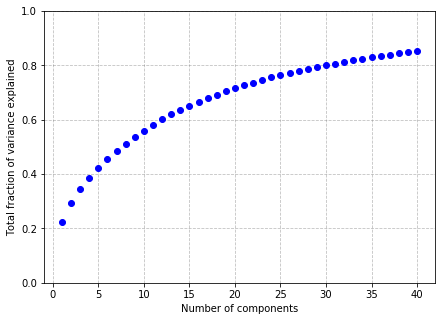

In [12]:
fig = plt.figure(figsize=(7, 5))
ax = plt.gca()

ax.plot(np.arange(1, max_n_components + 1), total_expl_var, 'bo')

ax.set_ylim(0., 1.)

ax.grid(ls='--', color='gray', alpha=0.5)

ax.set_xlabel('Number of components')
ax.set_ylabel('Total fraction of variance explained')

plt.show()

plt.close()

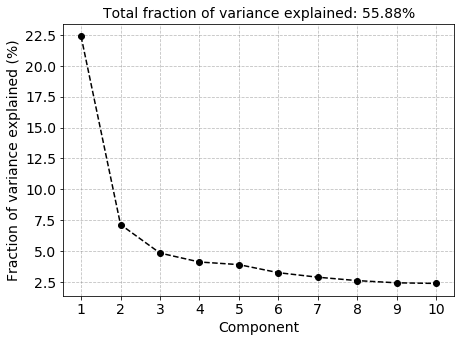

In [13]:
n_components = 10
eofs_ds = xr.open_dataset(sst_anom_pca_output_files[n_components])

fig = plt.figure(figsize=(7, 5))
ax = plt.gca()

ax.plot(eofs_ds['component'] + 1, 100.0 * eofs_ds['explained_variance_ratio'], 'ko', ls='--')

ax.grid(ls='--', color='gray', alpha=0.5)

ax.set_xlabel('Component', fontsize=14)
ax.set_ylabel('Fraction of variance explained (%)', fontsize=14)
ax.set_title(
    'Total fraction of variance explained: {:.2f}%'.format(eofs_ds['explained_variance_ratio'].sum().item() * 100.0),
    fontsize=14)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.tick_params(labelsize=14)

output_file = os.path.join(PLOTS_DIR, 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.pca.{}.k{:d}.explained_variance.pdf'.format(
    BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS,
    n_components))

plt.savefig(output_file, bbox_inches='tight')

plt.show()

plt.close()

eofs_ds.close()

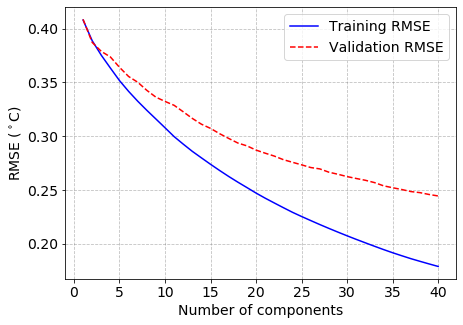

In [15]:
fig = plt.figure(figsize=(7, 5))
ax = plt.gca()

ax.plot(np.arange(1, max_n_components + 1), training_rmses, 'b-', label='Training RMSE')
ax.plot(np.arange(1, max_n_components + 1), validation_rmses, 'r--', label='Validation RMSE')

ax.grid(ls='--', color='gray', alpha=0.5)

ax.set_xlabel('Number of components', fontsize=14)
ax.set_ylabel('RMSE ($^\circ$C)', fontsize=14)
ax.tick_params(labelsize=14)

ax.legend(fontsize=14)

plt.show()

plt.close()

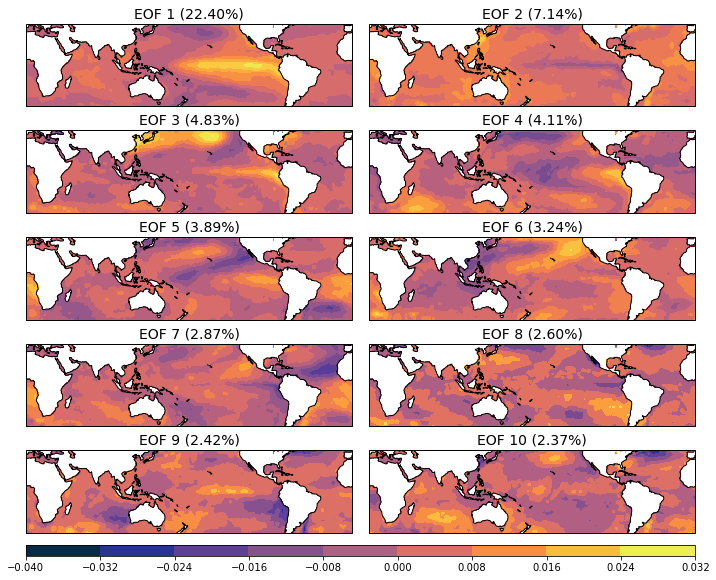

In [16]:
n_components = 10
eofs_ds = xr.open_dataset(sst_anom_pca_output_files[n_components])

components = eofs_ds['component'].values

projection = ccrs.PlateCarree(central_longitude=180)
wrap_lon = True

cmap = cmocean.cm.thermal

component_vmins = np.empty(n_components)
vmin = None
for i, component in enumerate(components):
    component_vmin = eofs_ds['EOFs'].sel(component=component).min().item()
    if vmin is None or component_vmin < vmin:
        vmin = component_vmin

component_vmins[:] = vmin

component_vmaxs = np.empty(n_components)
vmax = None
for i, component in enumerate(components):
    component_vmax = eofs_ds['EOFs'].sel(component=component).max().item()
    if vmax is None or component_vmax > vmax:
        vmax = component_vmax

component_vmaxs[:] = vmax

ncols = 2 if n_components % 2 == 0 else 3
nrows = int(np.ceil(n_components / ncols))
height_ratios = np.ones((nrows + 1))
height_ratios[-1] = 0.1

fig = plt.figure(constrained_layout=False, figsize=(6 * ncols, 2 * nrows))

gs = gridspec.GridSpec(ncols=ncols, nrows=nrows + 1, figure=fig,
                       wspace=0.05, hspace=0.01,
                       height_ratios=height_ratios)

lat = eofs_ds[LAT_NAME]
lon = eofs_ds[LON_NAME]

row_index = 0
col_index = 0
for i, component in enumerate(components):
    eof_data = eofs_ds['EOFs'].sel(component=component).values
    expl_var = eofs_ds['explained_variance_ratio'].sel(
        component=component).item()

    if wrap_lon:
        eof_data, eof_lon = add_cyclic_point(eof_data, coord=lon)

    lon_grid, lat_grid = np.meshgrid(eof_lon, lat)

    ax = fig.add_subplot(gs[row_index, col_index], projection=projection)

    ax.coastlines()
    ax.set_global()

    ax_vmin = component_vmins[i]
    ax_vmax = component_vmaxs[i]

    cs = ax.contourf(lon_grid, lat_grid, eof_data, vmin=ax_vmin, vmax=ax_vmax,
                     cmap=cmap, transform=ccrs.PlateCarree())

    ax.set_ylim([MIN_LATITUDE, MAX_LATITUDE])

    ax.set_title('EOF {} ({:.2f}%)'.format(
        component + 1, expl_var * 100), fontsize=14)
    ax.set_aspect('equal')
    fig.canvas.draw()

    col_index += 1
    if col_index == ncols:
        col_index = 0
        row_index += 1

cb_ax = fig.add_subplot(gs[-1, :])
cb = fig.colorbar(cs, cax=cb_ax, pad=0.05, orientation='horizontal')

output_file = os.path.join(PLOTS_DIR, 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.pca.{}.k{:d}.eofs.pdf'.format(
    BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS,
    n_components))

plt.savefig(output_file, bbox_inches='tight')

plt.show()

plt.close()

eofs_ds.close()

In [ ]:
sst_anom_ds.close()

The following plots are useful for building some intuition as to the distribution of
samples in the state-space.

In [ ]:
# 2D projections into PC space

n_components = 10
eofs_ds = xr.open_dataset(sst_anom_pca_output_files[n_components])

components = eofs_ds['component'].values

ncols = n_components - 1
nrows = n_components - 1

fig = plt.figure(constrained_layout=False, figsize=(3 * ncols, 3 * nrows))

gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig,
                       wspace=0.35, hspace=0.25)

for row in range(n_components - 1):
    col_index = row
    for col in range(row + 1, n_components):
        
        x_coord = eofs_ds['PCs'].sel(component=row)
        y_coord = eofs_ds['PCs'].sel(component=col)
        
        ax = fig.add_subplot(gs[row, col_index])
        
        ax.plot(x_coord, y_coord, '.')
        
        ax.set_xlabel('PC {:d}'.format(row + 1))
        ax.set_ylabel('PC {:d}'.format(col + 1))
        
        col_index += 1

plt.show()

plt.close()

eofs_ds.close()

In [ ]:
def get_latitude_weights(da, lat_weights='scos', lat_name=LAT_NAME):
    """Get latitude weights."""

    if lat_weights == 'cos':
        return np.cos(np.deg2rad(da[lat_name])).clip(0., 1.)

    if lat_weights == 'scos':
        return np.cos(np.deg2rad(da[lat_name])).clip(0., 1.) ** 0.5

    if lat_weights == 'none':
        return xr.ones_like(da[lat_name])

    raise ValueError("Invalid weights descriptor '%r'" % lat_weights)


def weight_and_flatten_data(da, weights=None, sample_dim=TIME_NAME):
    """Apply weighting to data and convert to 2D array."""

    feature_dims = [d for d in da.dims if d != sample_dim]
    original_shape = [da.sizes[d] for d in da.dims if d != sample_dim]

    if weights is not None:
        weighted_da = (weights * da).transpose(*da.dims)
    else:
        weighted_da = da

    if weighted_da.get_axis_num(sample_dim) != 0:
        weighted_da = weighted_da.transpose(*([sample_dim] + feature_dims))

    n_samples = weighted_da.sizes[sample_dim]
    n_features = np.product(original_shape)

    flat_data = weighted_da.data.reshape(n_samples, n_features)

    return flat_data


def run_mds(da, n_components=2, lat_weights=LAT_WEIGHTS, metric=True,
            n_init=4, max_iter=300, verbose=0, eps=0.001, n_jobs=None,
            random_state=None, lat_name=LAT_NAME, sample_dim=TIME_NAME):
    """Run MDS on given data."""

    feature_dims = [d for d in da.dims if d != sample_dim]
    original_shape = [da.sizes[d] for d in da.dims if d != sample_dim]

    # Get requested latitude weights
    weights = get_latitude_weights(da, lat_weights=lat_weights,
                                   lat_name=lat_name)

    # Convert input data array to plain 2D array
    flat_data = weight_and_flatten_data(da, weights=weights, sample_dim=sample_dim)

    n_samples, n_features = flat_data.shape

    # Remove any features/columns with missing data
    missing_features = np.any(np.isnan(flat_data), axis=0)
    valid_data = flat_data[:, np.logical_not(missing_features)]
    
    mds = MDS(n_components=n_components, metric=metric, n_init=n_init,
              max_iter=max_iter, verbose=verbose, eps=eps, n_jobs=n_jobs,
              random_state=random_state, dissimilarity='euclidean').fit(valid_data)
    
    embedding_da = xr.DataArray(
        mds.embedding_,
        coords={sample_dim: da[sample_dim], 'component': np.arange(n_components)},
        dims=[sample_dim, 'component'])
    
    mds_ds = xr.Dataset(data_vars={'embedding': embedding_da})
    mds_ds.attrs['stress'] = '{:16.8e}'.format(mds.stress_)

    return mds_ds

In [ ]:
# 2D metric MDS with Euclidean distances

mds_2d_scos = run_mds(sst_anom_da, n_components=2, lat_weights='scos')

In [ ]:
fig = plt.figure(figsize=(7, 5))
ax = plt.gca()

ax.plot(mds_2d_scos['embedding'].sel(component=0), mds_2d_scos['embedding'].sel(component=1), '.')

ax.grid(ls='--', color='gray', alpha=0.5)

ax.set_xlabel('MDS coordinate 1')
ax.set_ylabel('MDS coordinate 2')

ax.set_title('2D metric MDS of scos weighted SST anomalies with Euclidean dissimilarity')

plt.show()

plt.close()

In [ ]:
# 2D non-metric MDS with Euclidean distances

mds_2d_scos = run_mds(sst_anom_da, n_components=2, lat_weights='scos', metric=False)

In [ ]:
fig = plt.figure(figsize=(7, 5))
ax = plt.gca()

ax.plot(mds_2d_scos['embedding'].sel(component=0), mds_2d_scos['embedding'].sel(component=1), '.')

ax.grid(ls='--', color='gray', alpha=0.5)

ax.set_xlabel('MDS coordinate 1')
ax.set_ylabel('MDS coordinate 2')

ax.set_title('2D non-metric MDS of scos weighted SST anomalies with Euclidean dissimilarity')

plt.show()

plt.close()

In [ ]:
# 3D metric MDS with Euclidean distances

mds_3d_scos = run_mds(sst_anom_da, n_components=3, lat_weights='scos')

In [ ]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(mds_3d_scos['embedding'].sel(component=0), mds_3d_scos['embedding'].sel(component=1),
           mds_3d_scos['embedding'].sel(component=2), '.')

ax.set_xlabel('MDS coordinate 1')
ax.set_ylabel('MDS coordinate 2')
ax.set_zlabel('MDS coordinate 3')

ax.set_title('3D metric MDS of scos weighted SST anomalies with Euclidean dissimilarity')

ax.view_init(elev=30, azim=45)

plt.show()

plt.close()

In [ ]:
# 3D non-metric MDS with Euclidean distances

mds_3d_scos = run_mds(sst_anom_da, n_components=3, lat_weights='scos', metric=False)

In [ ]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(mds_3d_scos['embedding'].sel(component=0), mds_3d_scos['embedding'].sel(component=1),
           mds_3d_scos['embedding'].sel(component=2), '.')

ax.set_xlabel('MDS coordinate 1')
ax.set_ylabel('MDS coordinate 2')
ax.set_zlabel('MDS coordinate 3')

ax.set_title('3D non-metric MDS of scos weighted SST anomalies with Euclidean dissimilarity')

ax.view_init(elev=30, azim=90)

plt.show()

plt.close()

In [ ]:
# 5D metric MDS with Euclidean distances

mds_5d_scos = run_mds(sst_anom_da, n_components=5, lat_weights='scos')

In [ ]:
# 2D projections into MDS space

ncols = 4
nrows = 4

fig = plt.figure(constrained_layout=False, figsize=(4 * ncols, 4 * nrows))

gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig,
                       wspace=0.35, hspace=0.25)

for row in range(4):
    col_index = row
    for col in range(row + 1, 5):
        
        x_coord = mds_5d_scos['embedding'].sel(component=row)
        y_coord = mds_5d_scos['embedding'].sel(component=col)
        
        ax = fig.add_subplot(gs[row, col_index])
        
        ax.plot(x_coord, y_coord, '.')
        
        ax.set_xlabel('MDS coordinate {:d}'.format(row + 1))
        ax.set_ylabel('MDS coordinate {:d}'.format(col + 1))
        
        col_index += 1

plt.show()

plt.close()

In [ ]:
def run_tsne(da, lat_weights=LAT_WEIGHTS, n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0,
             n_iter=1000, n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean',
             init='random', verbose=0, random_state=None, method='barnes_hut', angle=0.5,
             n_jobs=None, lat_name=LAT_NAME, sample_dim=TIME_NAME):
    """Run t-SNE on given data."""

    feature_dims = [d for d in da.dims if d != sample_dim]
    original_shape = [da.sizes[d] for d in da.dims if d != sample_dim]

    # Get requested latitude weights
    weights = get_latitude_weights(da, lat_weights=lat_weights,
                                   lat_name=lat_name)

    # Convert input data array to plain 2D array
    flat_data = weight_and_flatten_data(da, weights=weights, sample_dim=sample_dim)

    n_samples, n_features = flat_data.shape

    # Remove any features/columns with missing data
    missing_features = np.any(np.isnan(flat_data), axis=0)
    valid_data = flat_data[:, np.logical_not(missing_features)]

    tsne = TSNE(n_components=n_components, perplexity=perplexity,
                early_exaggeration=early_exaggeration, learning_rate=learning_rate,
                n_iter=n_iter, n_iter_without_progress=n_iter_without_progress,
                min_grad_norm=min_grad_norm, metric=metric, init=init, verbose=verbose,
                random_state=random_state, method=method, angle=angle, n_jobs=n_jobs).fit(valid_data)
    
    embedding_da = xr.DataArray(
        tsne.embedding_,
        coords={sample_dim: da[sample_dim], 'component': np.arange(n_components)},
        dims=[sample_dim, 'component'])
    
    tsne_ds = xr.Dataset(data_vars={'embedding': embedding_da})
    tsne_ds.attrs['kl_divergence'] = '{:16.8e}'.format(tsne.kl_divergence_)
    tsne_ds.attrs['n_iter'] = '{:d}'.format(tsne.n_iter_)

    return tsne_ds

In [ ]:
perplexities = [5, 10, 30, 50, 100, 200]
tsne_2d_scos_results = []
for p in perplexities:
    tsne_2d_scos_results.append(run_tsne(sst_anom_da, lat_weights='scos', n_components=2,
                                         perplexity=p, learning_rate=50.0, n_iter=20000, verbose=1))

In [ ]:
for i, p in enumerate(perplexities):

    fig = plt.figure(figsize=(7, 5))
    ax = plt.gca()

    cs=ax.scatter(tsne_2d_scos_results[i]['embedding'].sel(component=0), tsne_2d_scos_results[i]['embedding'].sel(component=1),# '.',
                  c=np.arange(tsne_2d_scos_results[i].sizes[TIME_NAME], dtype='f8'))
    cb = plt.colorbar(cs)

    ax.grid(ls='--', color='gray', alpha=0.5)

    ax.set_xlabel('t-SNE coordinate 1')
    ax.set_ylabel('t-SNE coordinate 2')

    ax.set_title('2D t-SNE of scos weighted SST anomalies with Euclidean metric, perplexity = {:.2f}'.format(p))

    plt.show()

    plt.close()

## EOF analysis of standardized SST anomalies

In addition to working with the raw anomalies, we repeat the analysis using monthly standardized anomalies.

In [ ]:
sst_std_anom_ds = xr.open_dataset(SST_STD_ANOM_INPUT_FILE)

sst_std_anom_ds = sst_std_anom_ds.where(
    (sst_std_anom_ds[TIME_NAME].dt.year >= START_YEAR) &
    (sst_std_anom_ds[TIME_NAME].dt.year <= END_YEAR), drop=True)

sst_std_anom_ds = sst_std_anom_ds.where(
    (sst_std_anom_ds[LAT_NAME] >= MIN_LATITUDE) &
    (sst_std_anom_ds[LAT_NAME] <= MAX_LATITUDE), drop=True)

sst_std_anom_da = sst_std_anom_ds[STANDARDIZED_ANOMALY_NAME]

if RESTRICT_TO_CLIMATOLOGY_BASE_PERIOD:
    clim_base_period = [int(sst_std_anom_ds.attrs['base_period_start_year']),
                        int(sst_std_anom_ds.attrs['base_period_end_year'])]

    sst_std_anom_da = sst_std_anom_da.where(
        (sst_std_anom_da[TIME_NAME].dt.year >= clim_base_period[0]) &
        (sst_std_anom_da[TIME_NAME].dt.year <= clim_base_period[1]), drop=True)

In [ ]:
max_n_components = 40

total_expl_var = []
training_rmses = []
validation_rmses = []

sst_std_anom_pca_output_files = {}

def write_std_eofs_to_file(ds, n_components):
    output_file = os.path.join(RESULTS_DIR, 'HadISST_sst.std_anom.{:d}_{:d}.trend_order{:d}.pca.{}.k{:d}.nc'.format(
        BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS, n_components))
    
    ds.to_netcdf(output_file)
    
    return output_file


for k in range(2, max_n_components + 1):

    eofs_ds = run_pca(sst_std_anom_da, n_components=k, tolerance=TOLERANCE, lat_weights=LAT_WEIGHTS,
                      random_state=random_state)
    
    total_expl_var.append(eofs_ds['explained_variance_ratio'].sum())
    training_rmses.append(float(eofs_ds.attrs['training_set_rmse']))
    validation_rmses.append(float(eofs_ds.attrs['test_set_rmse']))
    
    sst_std_anom_pca_output_files[k] = write_std_eofs_to_file(eofs_ds, n_components=k)
    
    print('* PCA with k = {:d} required time: {}'.format(k, eofs_ds.attrs['elapsed_time']))
    
rmse_output_file = os.path.join(CSV_DIR, 'HadISST_sst.std_anom.{:d}_{:d}.trend_order{:d}.pca.{}.rmse.csv'.format(
        BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS))

header = 'n_components,training_rmse,validation_rmse'
fmt = '%d,%16.8e,%16.8e'

data = np.zeros((np.size(training_rmses), 3))
data[:, 0] = np.arange(2, max_n_components + 1)
data[:, 1] = training_rmses
data[:, 2] = validation_rmses

np.savetxt(rmse_output_file, data, header=header, fmt=fmt)

In [ ]:
fig = plt.figure(figsize=(7, 5))
ax = plt.gca()

ax.plot(np.arange(2, max_n_components + 1), total_expl_var, 'bo')

ax.set_ylim(0., 1.)

ax.grid(ls='--', color='gray', alpha=0.5)

ax.set_xlabel('Number of components')
ax.set_ylabel('Total fraction of variance explained')

plt.show()

plt.close()

In [ ]:
eofs_ds = xr.open_dataset(sst_std_anom_pca_output_files[15])

fig = plt.figure(figsize=(7, 5))
ax = plt.gca()

ax.plot(eofs_ds['component'] + 1, 100.0 * eofs_ds['explained_variance_ratio'], 'ko', ls='--')

ax.grid(ls='--', color='gray', alpha=0.5)

ax.set_xlabel('Component', fontsize=14)
ax.set_ylabel('Fraction of variance explained (%)', fontsize=14)
ax.set_title(
    'Total fraction of variance explained: {:.2f}%'.format(eofs_ds['explained_variance_ratio'].sum().item() * 100.0),
    fontsize=14)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.tick_params(labelsize=14)

plt.show()

plt.close()

eofs_ds.close()

In [ ]:
fig = plt.figure(figsize=(7, 5))
ax = plt.gca()

ax.plot(np.arange(2, max_n_components + 1), training_rmses, 'b-', label='Training RMSE')
ax.plot(np.arange(2, max_n_components + 1), validation_rmses, 'r--', label='Validation RMSE')

ax.grid(ls='--', color='gray', alpha=0.5)

ax.set_xlabel('Number of components', fontsize=14)
ax.set_ylabel('RMSE ($^\circ$C)', fontsize=14)
ax.tick_params(labelsize=14)

ax.legend(fontsize=14)

plt.show()

plt.close()

In [ ]:
eofs_ds = xr.open_dataset(sst_std_anom_pca_output_files[10])

components = eofs_ds['component'].values
n_components = eofs_ds.sizes['component']

projection = ccrs.PlateCarree(central_longitude=180)
wrap_lon = True

cmap = cmocean.cm.thermal

component_vmins = np.empty(n_components)
vmin = None
for i, component in enumerate(components):
    component_vmin = eofs_ds['EOFs'].sel(component=component).min().item()
    if vmin is None or component_vmin < vmin:
        vmin = component_vmin

component_vmins[:] = vmin

component_vmaxs = np.empty(n_components)
vmax = None
for i, component in enumerate(components):
    component_vmax = eofs_ds['EOFs'].sel(component=component).max().item()
    if vmax is None or component_vmax > vmax:
        vmax = component_vmax

component_vmaxs[:] = vmax

ncols = 2 if n_components % 2 == 0 else 3
nrows = int(np.ceil(n_components / ncols))
height_ratios = np.ones((nrows + 1))
height_ratios[-1] = 0.1

fig = plt.figure(constrained_layout=False, figsize=(4 * ncols, 1.5 * nrows))

gs = gridspec.GridSpec(ncols=ncols, nrows=nrows + 1, figure=fig,
                       wspace=0.05, hspace=0.01,
                       height_ratios=height_ratios)

lat = eofs_ds[LAT_NAME]
lon = eofs_ds[LON_NAME]

row_index = 0
col_index = 0
for i, component in enumerate(components):
    eof_data = eofs_ds['EOFs'].sel(component=component).values
    expl_var = eofs_ds['explained_variance_ratio'].sel(
        component=component).item()

    if wrap_lon:
        eof_data, eof_lon = add_cyclic_point(eof_data, coord=lon)

    lon_grid, lat_grid = np.meshgrid(eof_lon, lat)

    ax = fig.add_subplot(gs[row_index, col_index], projection=projection)

    ax.coastlines()
    ax.set_global()

    ax_vmin = component_vmins[i]
    ax_vmax = component_vmaxs[i]

    cs = ax.contourf(lon_grid, lat_grid, eof_data, vmin=ax_vmin, vmax=ax_vmax,
                     cmap=cmap, transform=ccrs.PlateCarree())

    ax.set_ylim([MIN_LATITUDE, MAX_LATITUDE])

    ax.set_title('EOF {} ({:.2f}%)'.format(
        component + 1, expl_var * 100))
    ax.set_aspect('equal')
    fig.canvas.draw()

    col_index += 1
    if col_index == ncols:
        col_index = 0
        row_index += 1

cb_ax = fig.add_subplot(gs[-1, :])
cb = fig.colorbar(cs, cax=cb_ax, pad=0.05, orientation='horizontal')

plt.show()

plt.close()

eofs_ds.close()

In [ ]:
sst_std_anom_ds.close()